In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [3]:
filter_size1 = 5
num_filters1 = 16

filter_size2 = 5
num_filters2 = 36

fc_size = 128

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [7]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [8]:
data.test.cls = np.argmax(data.test.labels, axis = 1)

In [11]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_channels = 1
num_classes = 10

In [18]:
def plot_images(images, cls_true, cls_pred = None):
    assert len(images) == len(cls_true) == 9
    
    fig,axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap = 'binary')
        
        if cls_pred is None:
            xlabel = "True : {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i],cls_pred[i])
        
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

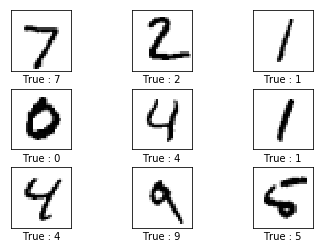

In [21]:
images = data.test.images[0:9]
cls_true = data.test.cls[0:9]
plot_images(images = images, cls_true = cls_true)

In [22]:
def new_weights(shape):
    return(tf.Variable(tf.truncated_normal(shape, stddev = 0.05)))

In [24]:
def new_biases(length):
    return(tf.Variable(tf.constant(0.05, shape = [length])))

In [48]:
def new_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling = True):
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape = shape)
    biases = new_biases(length = num_filters)
    
    layer = tf.nn.conv2d(input = input, filter = weights, strides = [1,1,1,1], padding = 'SAME')
    layer = layer + biases
    
    layer = tf.nn.max_pool(value = layer, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    layer = tf.nn.relu(layer)
    
    return(layer, weights)

In [61]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return(layer_flat, num_features)

In [68]:
def new_fc_layer(input, num_inputs, num_outputs, use_relu = True):
    weights = new_weights(shape = [num_inputs, num_outputs])
    biases = new_biases(length = num_outputs)
    layer = tf.matmul(input, weights) + biases
    layer = tf.nn.relu(layer)
    return(layer)

In [33]:
x = tf.placeholder(tf.float32, shape = [None, img_size_flat], name = 'x')

In [34]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [36]:
y_true = tf.placeholder(tf.float32, shape = [None, num_classes],name = 'y_true')

In [38]:
y_true_cls = tf.argmax(y_true, dimension = 1)

In [49]:
layer_conv1, weights_conv1 = new_conv_layer(input = x_image,
                                           num_input_channels = num_channels,
                                           filter_size = filter_size1,
                                           num_filters = num_filters1,
                                           use_pooling = True)

In [51]:
layer_conv1

<tf.Tensor 'Relu_1:0' shape=(?, 14, 14, 16) dtype=float32>

In [54]:
layer_conv2, weights_conv2 = new_conv_layer(input = layer_conv1, num_input_channels = num_filters1,
                                           filter_size = filter_size2,
                                           num_filters = num_filters2,
                                           use_pooling = True)

In [55]:
layer_conv2

<tf.Tensor 'Relu_3:0' shape=(?, 7, 7, 36) dtype=float32>

In [62]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [64]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [66]:
num_features

1764

In [71]:
layer_fc1 = new_fc_layer(input = layer_flat, num_inputs = num_features, num_outputs = fc_size)

In [73]:
layer_fc1

<tf.Tensor 'Relu_5:0' shape=(?, 128) dtype=float32>

In [74]:
layer_fc2 = new_fc_layer(input = layer_fc1, num_inputs = fc_size, num_outputs = num_classes)

In [76]:
layer_fc2

<tf.Tensor 'Relu_6:0' shape=(?, 10) dtype=float32>

In [78]:
y_pred = tf.nn.softmax(layer_fc2)

In [80]:
y_pred_cls = tf.argmax(y_pred, dimension = 1)

In [82]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = layer_fc2, labels = y_true)

In [84]:
cost = tf.reduce_mean(cross_entropy)

In [87]:
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-4).minimize(cost)

In [90]:
correct_prediction = tf.equal(y_pred_cls ,  y_true_cls)

In [92]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [94]:
session = tf.Session()

In [96]:
session.run(tf.global_variables_initializer())

In [98]:
train_batch_size = 64

In [113]:
total_iterations = 0

def optimize(num_iterations):
    global total_iterations
    
    start_time = time.time()
    for i in range(total_iterations, total_iterations + num_iterations):
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        session.run(optimizer, feed_dict = feed_dict_train)
        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict= feed_dict_train)
            msg = "Optimization Iteration : {0:>6}, Training Accuracy : {1:>6.1%}"
            print(msg.format(i+1, acc))
    
    total_iterations = total_iterations + num_iterations
    end_time = time.time()
    time_diff = end_time = start_time
    #print("Time: " + str(timedelta(seconds = int(round(time_diff)))))
    print("Time: ", time_diff)

In [103]:
test_batch_size = 256

def print_test_accuracy():
    num_test = len(data.test.images)
    cls_pred = np.zeros(shape = num_test, dtype = np.int)
    i = 0
    while i < num_test:
        j = min(i + test_batch_size, num_test)
        images = data.test.images[i:j, :]
        labels = data.test.labels[i:j, :]
        feed_dict = {x: images,
                    y_true: labels}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict = feed_dict)
        i = j
    
    cls_true = data.test.cls
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    
    acc = float(correct_sum) / num_test
    msg = "Accuracy on Test Set : {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    

In [105]:
print_test_accuracy()

Accuracy on Test Set : 9.7% (969 / 10000)


In [114]:
optimize(num_iterations = 5)

Optimization Iteration :      1, Training Accuracy :  18.8%
Time:  1496633956.4518738


In [112]:
print_test_accuracy()

Accuracy on Test Set : 14.6% (1463 / 10000)


In [117]:
optimize(num_iterations = 1000)

Optimization Iteration :    701, Training Accuracy :  73.4%
Optimization Iteration :    801, Training Accuracy :  73.4%
Optimization Iteration :    901, Training Accuracy :  70.3%
Optimization Iteration :   1001, Training Accuracy :  70.3%
Optimization Iteration :   1101, Training Accuracy :  76.6%
Optimization Iteration :   1201, Training Accuracy :  84.4%
Optimization Iteration :   1301, Training Accuracy :  85.9%
Optimization Iteration :   1401, Training Accuracy :  68.8%
Optimization Iteration :   1501, Training Accuracy :  67.2%
Optimization Iteration :   1601, Training Accuracy :  73.4%
Time:  1496634028.379516


In [118]:
print_test_accuracy()

Accuracy on Test Set : 77.0% (7703 / 10000)
